#### Cargas las librerías

In [1]:
# Load Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
import os
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf

from evaluation._mae import MAE
from evaluation._smape import sMAPE
from evaluation._mape import MAPE
from evaluation._rmse import RMSE
from keras.callbacks import EarlyStopping

#### Cargar dataset

In [2]:
s_path=Path.cwd()
s_prt_path=s_path.parent

file=os.path.join(s_prt_path,'datasets\XM_H_sinOfe.csv')
df_Data= pd.read_csv(file, index_col=0)
# df_Data.reset_index(inplace=True)

In [3]:
df_Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52584 entries, 01/01/2013 0:00 to 31/12/2018 23:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PrecioB    52584 non-null  float64
 1   Demanda    52584 non-null  float64
 2   DispTer    52584 non-null  int64  
 3   DispNoTer  52584 non-null  int64  
 4   VolUtil    52584 non-null  int64  
 5   Aportes    52584 non-null  int64  
 6   day_cls    52584 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 3.2+ MB


#### Funciones necesarias para las ejecuciones

##### División de datos

In [4]:
# Dividir los datos en train, validación y test
def split_data(data, indexTotal, train_fraq, test_len=8760):

    #slice the last year of data for testing 1 year has 8760 hours
    test_slice = len(data)-test_len

    test_data = data[test_slice:]
    indexTest=indexTotal[test_slice:]

    train_val_data = data[:test_slice]
    index_val_data=indexTotal[:test_slice]

    #make train and validation from the remaining
    train_size = int(len(train_val_data) * train_fraq)
    
    train_data = train_val_data[:train_size]
    indexTrain=index_val_data[:train_size]

    val_data = train_val_data[train_size:]
    indexVal=index_val_data[train_size:]
    
    return train_data, val_data, test_data, indexTrain, indexVal, indexTest

##### Construcción del dataset

In [5]:
# Crear los datos para entrar al modelo, definición de ventanas
def window_dataset(data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=False, expand_dims=False):
    """ Create a windowed tensorflow dataset
    
    """

    #create a window with n steps back plus the size of the prediction length
    window = n_steps + n_horizon
    
    #expand dimensions to 3D to fit with LSTM inputs
    #creat the inital tensor dataset
    if expand_dims:
        ds = tf.expand_dims(data, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(ds)
    else:
        ds = tf.data.Dataset.from_tensor_slices(data)
    
    #create the window function shifting the data by the prediction length
    ds = ds.window(window, shift=n_horizon, drop_remainder=True)
    
    #flatten the dataset and batch into the window size
    ds = ds.flat_map(lambda x : x.batch(window))
    #ds = ds.shuffle(shuffle_buffer)
    
    #create the supervised learning problem x and y and batch
    if multi_var:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:, :1]))
    else:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:]))
    
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds

# Construcción del dataset usando las ventanas
def build_dataset(traindata,valdata,testdata,train_fraq=0.8, 
                  n_steps=24*30, 
                  n_horizon=24, 
                  batch_size=256, 
                  shuffle_buffer=500, 
                  expand_dims=False, 
                  multi_var=False):
    """If multi variate then first column is always the column from which the target is contstructed.
    """
    
    tf.random.set_seed(23)
    
    
    train_ds = window_dataset(traindata, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    val_ds = window_dataset(valdata, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    test_ds = window_dataset(testdata, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    
    
    print(f"Prediction lookback (n_steps): {n_steps}")
    print(f"Prediction horizon (n_horizon): {n_horizon}")
    print(f"Batch Size: {batch_size}")
    print("Datasets:")
    print(train_ds.element_spec)
    
    return train_ds, val_ds, test_ds

##### Parámetros y ejecución

In [6]:
# Definición de parámetros para la ejecución del modelo
def get_params(multivar=True):
    lr = 3e-4
    n_steps=72
    n_horizon=24
    if multivar:
        n_features=7
    else:
        n_features=1
        
    return n_steps, n_horizon, n_features, lr

# Almacenamiento de los datos de las ejecuciones
def cfg_model_run(model, history, test_ds):
    return {"model": model, "history" : history, "test_ds": test_ds}

# Ejecuciones de los modelos con función de ventanado
def run_model(traindata,valdata,testdata,model_name, model_func, model_configs, epochs):
    
    n_steps, n_horizon, n_features, lr = get_params(multivar=True)
    
    train_ds, val_ds, test_ds = build_dataset(traindata,valdata,testdata,n_steps=n_steps, n_horizon=n_horizon, multi_var=True)

    model = model_func(n_steps, n_horizon, n_features, lr=lr)

    # Define el early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=40)

    model_hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stopping])

    model_configs[model_name] = cfg_model_run(model, model_hist, test_ds)
    
    return test_ds


#### Modelos

##### DNN

In [7]:
def dnn_model(n_steps, n_horizon, n_features, lr):
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(n_steps, n_features)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='dnn')
    
    loss=tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae','mape'])
    
    return model


dnn = dnn_model(*get_params(multivar=True))
dnn.summary()

Model: "dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 504)               0         
                                                                 
 dense (Dense)               (None, 128)               64640     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 24)                3096      
                                                                 
Total params: 84248 (329.09 KB)
Trainable params: 84248 (329.09

##### LSTM

In [8]:
def lstm_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='lstm')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae','mape'])
    
    return model

lstm = lstm_model(*get_params(multivar=True))
lstm.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 72, 72)            23040     
                                                                 
 lstm_1 (LSTM)               (None, 48)                23232     
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 128)               6272      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 24)                3096   

##### GRU

In [9]:
def gru_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.GRU(72, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        tf.keras.layers.GRU(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='gru')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae','mape'])
    
    return model

gru = gru_model(*get_params(multivar=True))
gru.summary()

Model: "gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 72, 72)            17496     
                                                                 
 gru_1 (GRU)                 (None, 48)                17568     
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 128)               6272      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 24)                3096    

#### CNN_LSTM

In [10]:
def lstm_cnn_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.LSTM(72, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="lstm_cnn")
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae','mape'])
    
    return model

lstm_cnn = lstm_cnn_model(*get_params(multivar=True))
lstm_cnn.summary()

Model: "lstm_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 67, 64)            2752      
                                                                 
 max_pooling1d (MaxPooling1  (None, 33, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 31, 64)            12352     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 15, 64)            0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 15, 72)            39456     
                                                                 
 lstm_1 (LSTM)               (None, 48)                232

#### Escalamiento de los datos y división del dataset

In [11]:
#scale
scaler = MinMaxScaler(feature_range=(0, 1))
scalerP=MinMaxScaler(feature_range=(0, 1))

vec_precio=scalerP.fit_transform(df_Data.values[:,0].reshape(-1,1))

indexTotal=df_Data.index

multivar_df = scaler.fit_transform(df_Data)
train_multi, val_multi, test_multi, indexTrain, indexVal, indexTest = split_data(multivar_df,indexTotal, train_fraq=0.8, test_len=8760)
print("Multivarate Datasets")
print(f"Train Data Shape: {train_multi.shape}")
print(f"Val Data Shape: {val_multi.shape}")
print(f"Test Data Shape: {test_multi.shape}")
print(f"Nulls In Train {np.any(np.isnan(train_multi))}")
print(f"Nulls In Validation {np.any(np.isnan(val_multi))}")
print(f"Nulls In Test {np.any(np.isnan(test_multi))}")
print('Precio',vec_precio.shape)
print('Todo',df_Data.shape)

Multivarate Datasets
Train Data Shape: (35059, 7)
Val Data Shape: (8765, 7)
Test Data Shape: (8760, 7)
Nulls In Train False
Nulls In Validation False
Nulls In Test False
Precio (52584, 1)
Todo (52584, 7)


##### Obtener dataset para el modelo utilizando la función de ventanado

In [12]:
n_steps=72
n_horizon=24

train_ds, val_ds, test_ds = build_dataset(train_multi, val_multi, test_multi,n_steps=n_steps, n_horizon=n_horizon,multi_var=True)
print('Example sample shapes')
for idx,(x,y) in enumerate(train_ds):
    print("x = ", x.numpy().shape)
    print("y = ", y.numpy().shape)
    break

Prediction lookback (n_steps): 72
Prediction horizon (n_horizon): 24
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Example sample shapes
x =  (256, 72, 7)
y =  (256, 24, 1)


##### Ejecución de modelo con datos del ventanado

In [13]:
from sklearn.model_selection import KFold

model_configs_v = dict()
nepochs = 100

# Define the number of folds for cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits)

# Iterate over the folds
for fold, (train_index, val_index) in enumerate(kf.split(train_multi)):
    print(f"Fold {fold+1}/{n_splits}")
    
    # Get the training and validation data for the current fold
    fold_train_data = train_multi[train_index]
    fold_val_data = train_multi[val_index]
    
    print('Ejecutando la dnn')
    run_model(fold_train_data, fold_val_data, test_multi, "dnn", dnn_model, model_configs_v, epochs=nepochs)

    print('Ejecutando la lstm')
    run_model(fold_train_data, fold_val_data, test_multi, "lstm", lstm_model, model_configs_v, epochs=nepochs)

    print('Ejecutando la gru')
    run_model(fold_train_data, fold_val_data, test_multi, "gru", gru_model, model_configs_v, epochs=nepochs)

    print('Ejecutando la cnn_lstm')
    run_model(fold_train_data, fold_val_data, test_multi, "cnn_lstm", lstm_cnn_model, model_configs_v, epochs=nepochs)


Fold 1/5
Ejecutando la dnn
Prediction lookback (n_steps): 72
Prediction horizon (n_horizon): 24
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/100
5/5 [==============================] - 6s 433ms/step - loss: 0.0825 - mae: 0.3122 - mape: 2549.2522 - val_loss: 0.0051 - val_mae: 0.0796 - val_mape: 301.5274
Epoch 2/100
5/5 [==============================] - 1s 139ms/step - loss: 0.0132 - mae: 0.1227 - mape: 7004.3203 - val_loss: 0.0010 - val_mae: 0.0355 - val_mape: 131.2937
Epoch 3/100
5/5 [==============================] - 1s 132ms/step - loss: 0.0070 - mae: 0.0782 - mape: 1368.3184 - val_loss: 7.3789e-04 - val_mae: 0.0307 - val_mape: 96.8499
Epoch 4/100
5/5 [==============================] - 1s 168ms/step - loss: 0.0063 - mae: 0.0718 - mape: 1506.0402 - val_loss: 6.4278e-04 - val_mae: 0.0277 - val_mape: 110.5929
Epoch 5/100
5/5 [==============================] - 1s 130ms/st

#### Gráficas de entrenamiento modelo con ventanado

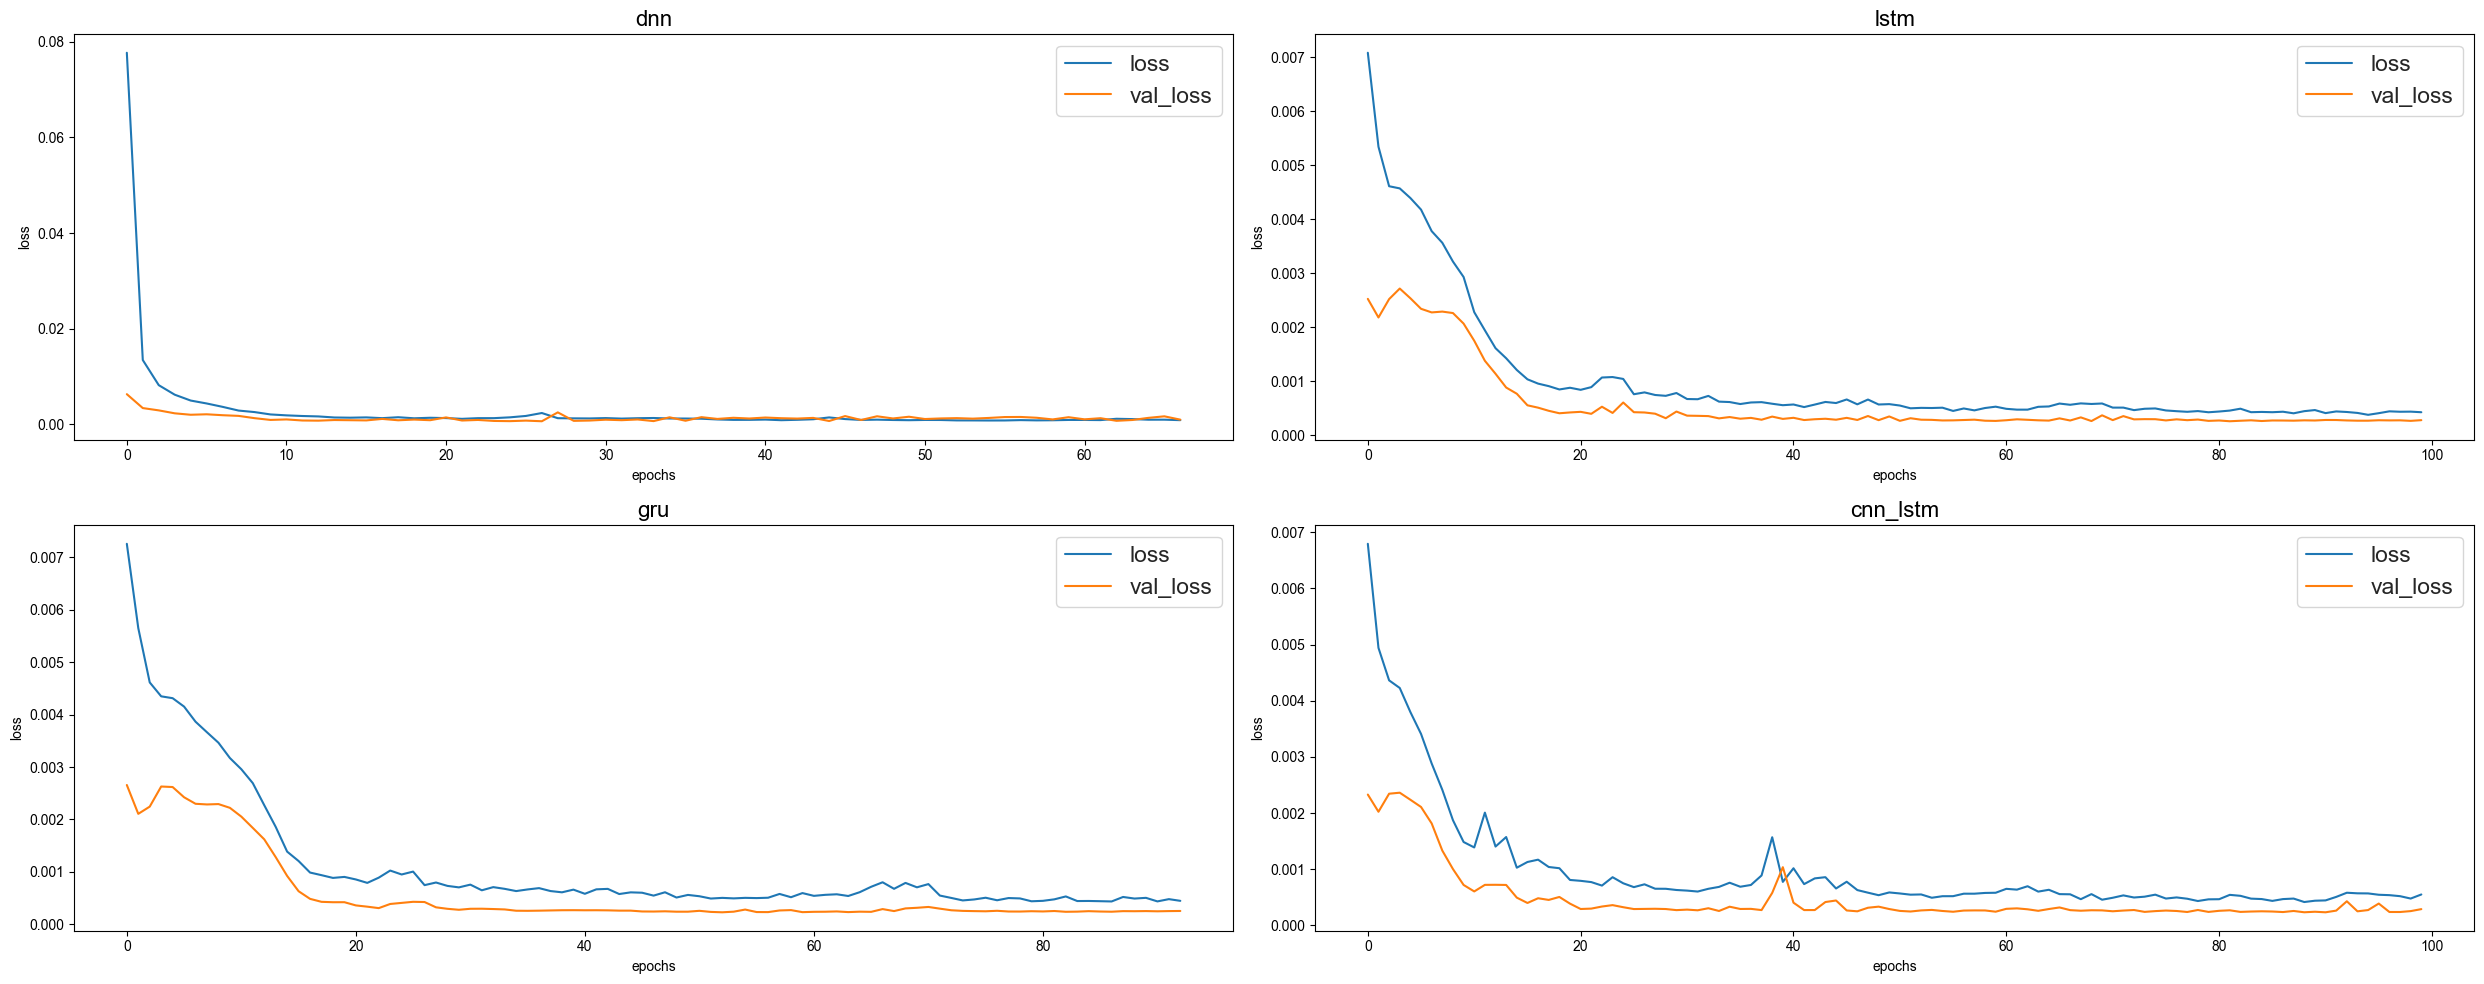

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(25,10))

metric='loss'

i=0
i1=0
for (key, val) in model_configs_v.items():
    # sns.lineplot(val['history'].history[metric],ax=axs[i1,i])
    # sns.lineplot(val['history'].history[f'val_{metric}'],ax=axs[i1,i])
    sns.set(font_scale=1.5,rc={'font.size': 12, 'axes.titlesize': 16})
    axs[i1,i].set_facecolor('white')
    axs[i1,i].plot(val['history'].history[metric])
    axs[i1,i].plot(val['history'].history[f'val_{metric}'])
    axs[i1,i].set_title(key)
    axs[i1,i].legend([metric, f"val_{metric}"],facecolor='white')
    axs[i1,i].set_xlabel('epochs')
    axs[i1,i].set_ylabel(metric)
    # axs[i1,i].set_ylim([0, 0.1])
    i=i+1
    if i==2:
        i1=1
        i=0

plt.tight_layout()  

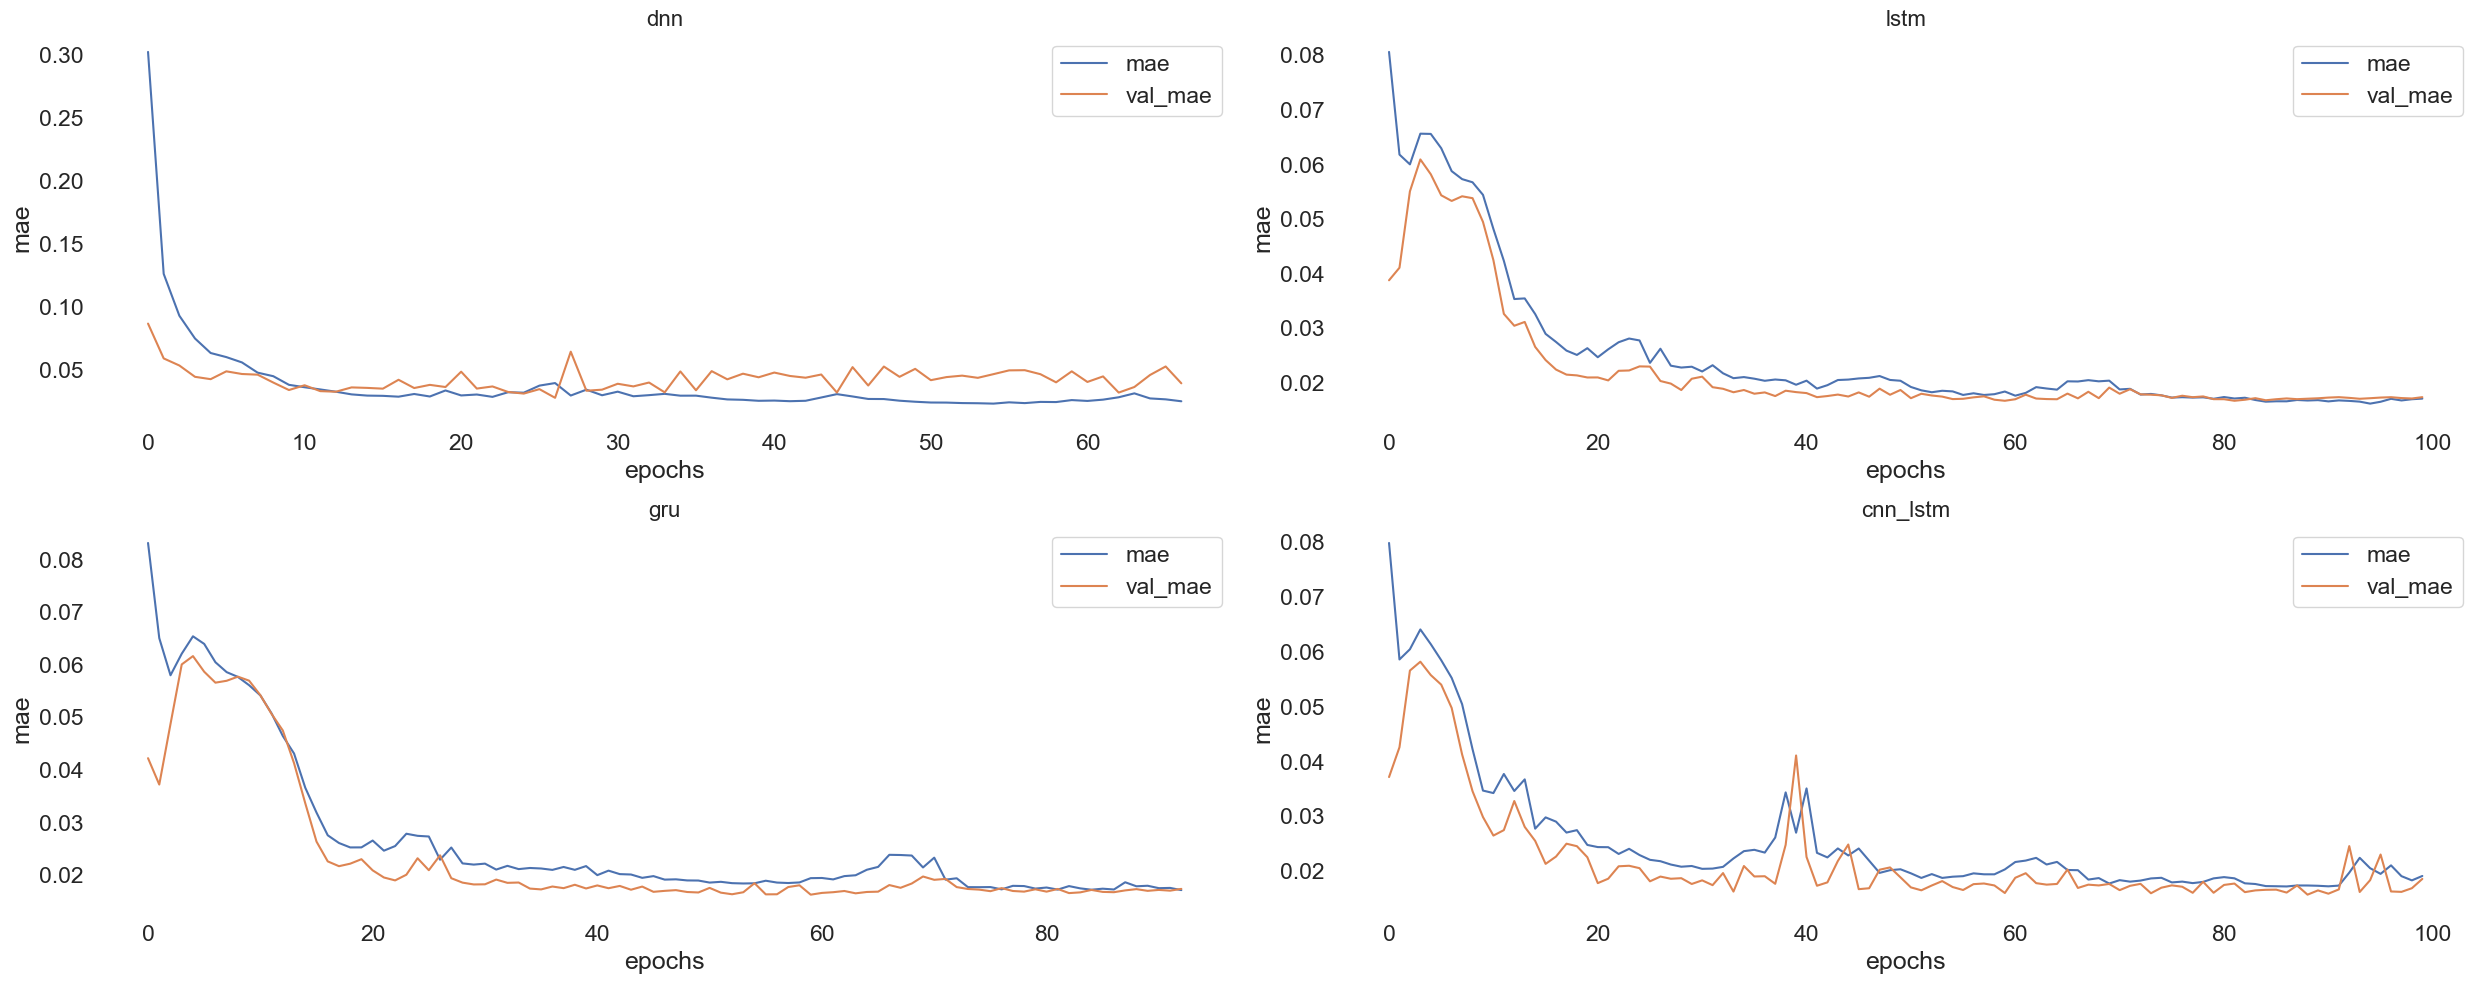

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(25,10))

metric='mae'

i=0
i1=0
for (key, val) in model_configs_v.items():
    # sns.lineplot(val['history'].history[metric],ax=axs[i1,i])
    # sns.lineplot(val['history'].history[f'val_{metric}'],ax=axs[i1,i])
    sns.set(font_scale=1.5,rc={'font.size': 12, 'axes.titlesize': 16})
    axs[i1,i].set_facecolor('white')
    axs[i1,i].plot(val['history'].history[metric])
    axs[i1,i].plot(val['history'].history[f'val_{metric}'])
    axs[i1,i].set_title(key)
    axs[i1,i].legend([metric, f"val_{metric}"],facecolor='white')
    axs[i1,i].set_xlabel('epochs')
    axs[i1,i].set_ylabel(metric)
    # axs[i1,i].set_ylim([0, 0.1])
    i=i+1
    if i==2:
        i1=1
        i=0

plt.tight_layout()  

##### Evaluar modelo con ventanado

In [16]:
print('Example sample shapes')
for idx,(x,y) in enumerate(train_ds):
    print("x = ", x.numpy().shape)
    print("y = ", y.numpy().shape)
    Xtr= x.numpy()
    Ytr=y.numpy()
    break

for idx,(x,y) in enumerate(val_ds):
    print("x = ", x.numpy().shape)
    print("y = ", y.numpy().shape)
    Xval= x.numpy()
    Yval=y.numpy()
    break

for idx,(x,y) in enumerate(test_ds):
    print("x = ", x.numpy().shape)
    print("y = ", y.numpy().shape)
    Xts= x.numpy()
    Yts=y.numpy()
    break

Example sample shapes
x =  (256, 72, 7)
y =  (256, 24, 1)
x =  (256, 72, 7)
y =  (256, 24, 1)
x =  (256, 72, 7)
y =  (256, 24, 1)


In [17]:
import pandas as pd
models=['dnn','lstm','gru','cnn_lstm']
# results=pd.DataFrame(columns=['Model','Tipo','MAE','MAPE','sMAPE','RMSE'])
results = []
resultsYtestP={}
listP=[]

# fechaIni=
# FechaFin=

listreg=[i for i in range(3)]


Xtrm=Xtr[listreg]
Ytrm=Ytr[listreg]
Xvalm=Xval[listreg]
Yvalm=Yval[listreg]
Xtsm=Xts[listreg]
Ytsm=Yts[listreg]

for mod in models:
    #Obtener el modelo
    tipomodelo=model_configs_v[mod]
    model=tipomodelo['model']

    #Evaluación de los X de entrenamiento
    Yp=model.predict(Xtrm)
    Ye=scalerP.inverse_transform(Ytrm.reshape(Ytrm.shape[0],n_horizon))
    Yp=scalerP.inverse_transform(Yp)
    mae_validation = np.mean(MAE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))
    mape_validation= np.mean(MAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
    smape_validation = np.mean(sMAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
    rmse_validation = np.mean(RMSE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))

    data={'Model':mod,'Tipo':'Train','MAE':mae_validation,'MAPE':mape_validation,
        'sMAPE':smape_validation,'RMSE':rmse_validation}
    results.append(data)
    #Evaluación de las X en validación
    Yp=model.predict(Xvalm)
    Ye=scalerP.inverse_transform(Yvalm.reshape(Yvalm.shape[0],n_horizon))
    Yp=scalerP.inverse_transform(Yp)
    mae_validation = np.mean(MAE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))
    mape_validation= np.mean(MAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
    smape_validation = np.mean(sMAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
    rmse_validation = np.mean(RMSE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))

    data={'Model':mod,'Tipo':'Val','MAE':mae_validation,'MAPE':mape_validation,
        'sMAPE':smape_validation,'RMSE':rmse_validation}

    results.append(data)

    # Hacer pedicciones con el Xtest
    # Xts=tipomodelo['Xts']
    # Yts=tipomodelo['Yts'].reshape(Yts.shape[0],24)
    Yp=model.predict(Xtsm)
    Ye=scalerP.inverse_transform(Ytsm.reshape(Ytsm.shape[0],n_horizon))
    Yp=scalerP.inverse_transform(Yp)
    listP.append(Ye)
    listP.append(Yp)

    mae_validation = np.mean(MAE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))
    mape_validation= np.mean(MAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
    smape_validation = np.mean(sMAPE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1))) * 100
    rmse_validation = np.mean(RMSE(Ye.flatten().reshape(-1,1), Yp.flatten().reshape(-1,1)))

    data={'Model':mod,'Tipo':'Test','MAE':mae_validation,'MAPE':mape_validation,
        'sMAPE':smape_validation,'RMSE':rmse_validation}
    results.append(data)
    df = pd.DataFrame(results, columns=['Model','Tipo','MAE','MAPE','sMAPE','RMSE'])

    resultsYtestP[mod]=listP
    listP=[]
df = pd.DataFrame(results, columns=['Model','Tipo','MAE','MAPE','sMAPE','RMSE'])


1/1 [==============================] - 0s 29ms/step


In [18]:
file=os.path.join(s_prt_path,'datasets\Results_' + str(n_steps) + '_' + str(n_horizon) + '_sinOfe_80_20_earlystop_kfolds.csv')
df.to_csv(file)

In [19]:
df

,Model,Tipo,MAE,MAPE,sMAPE,RMSE
0,dnn,Train,15.302674,8.566583,8.991306,19.203119
1,dnn,Val,84.769596,95.740692,59.783603,91.100605
2,dnn,Test,35.051423,24.977161,21.751933,38.787084
3,lstm,Train,17.116317,9.544952,10.340306,21.716582
4,lstm,Val,50.888709,60.016414,41.920274,58.364265
5,lstm,Test,16.138174,11.553944,10.705126,19.211779
6,gru,Train,18.848080,10.523825,11.496596,23.771350
7,gru,Val,56.505022,65.655076,45.199891,63.193002
8,gru,Test,18.480300,13.191469,12.115928,21.770635
9,cnn_lstm,Train,14.225642,7.903765,7.994237,16.454671


#### Gráfica del original y del pronóstico

dnn {'model': <keras.src.engine.sequential.Sequential object at 0x0000023C414F4AD0>, 'history': <keras.src.callbacks.History object at 0x0000023C4724E650>, 'test_ds': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>}
1/1 [==============================] - 0s 5ms/step
lstm {'model': <keras.src.engine.sequential.Sequential object at 0x0000023C47261E50>, 'history': <keras.src.callbacks.History object at 0x0000023C43D31CD0>, 'test_ds': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>}
1/1 [==============================] - 0s 15ms/step
gru {'model': <keras.src.engine.sequential.Sequential object at 0x0000023C46A5BC50>, 'history': <keras.src.callbacks.History object at 0x0000023C39920F10>, 'test_ds': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype

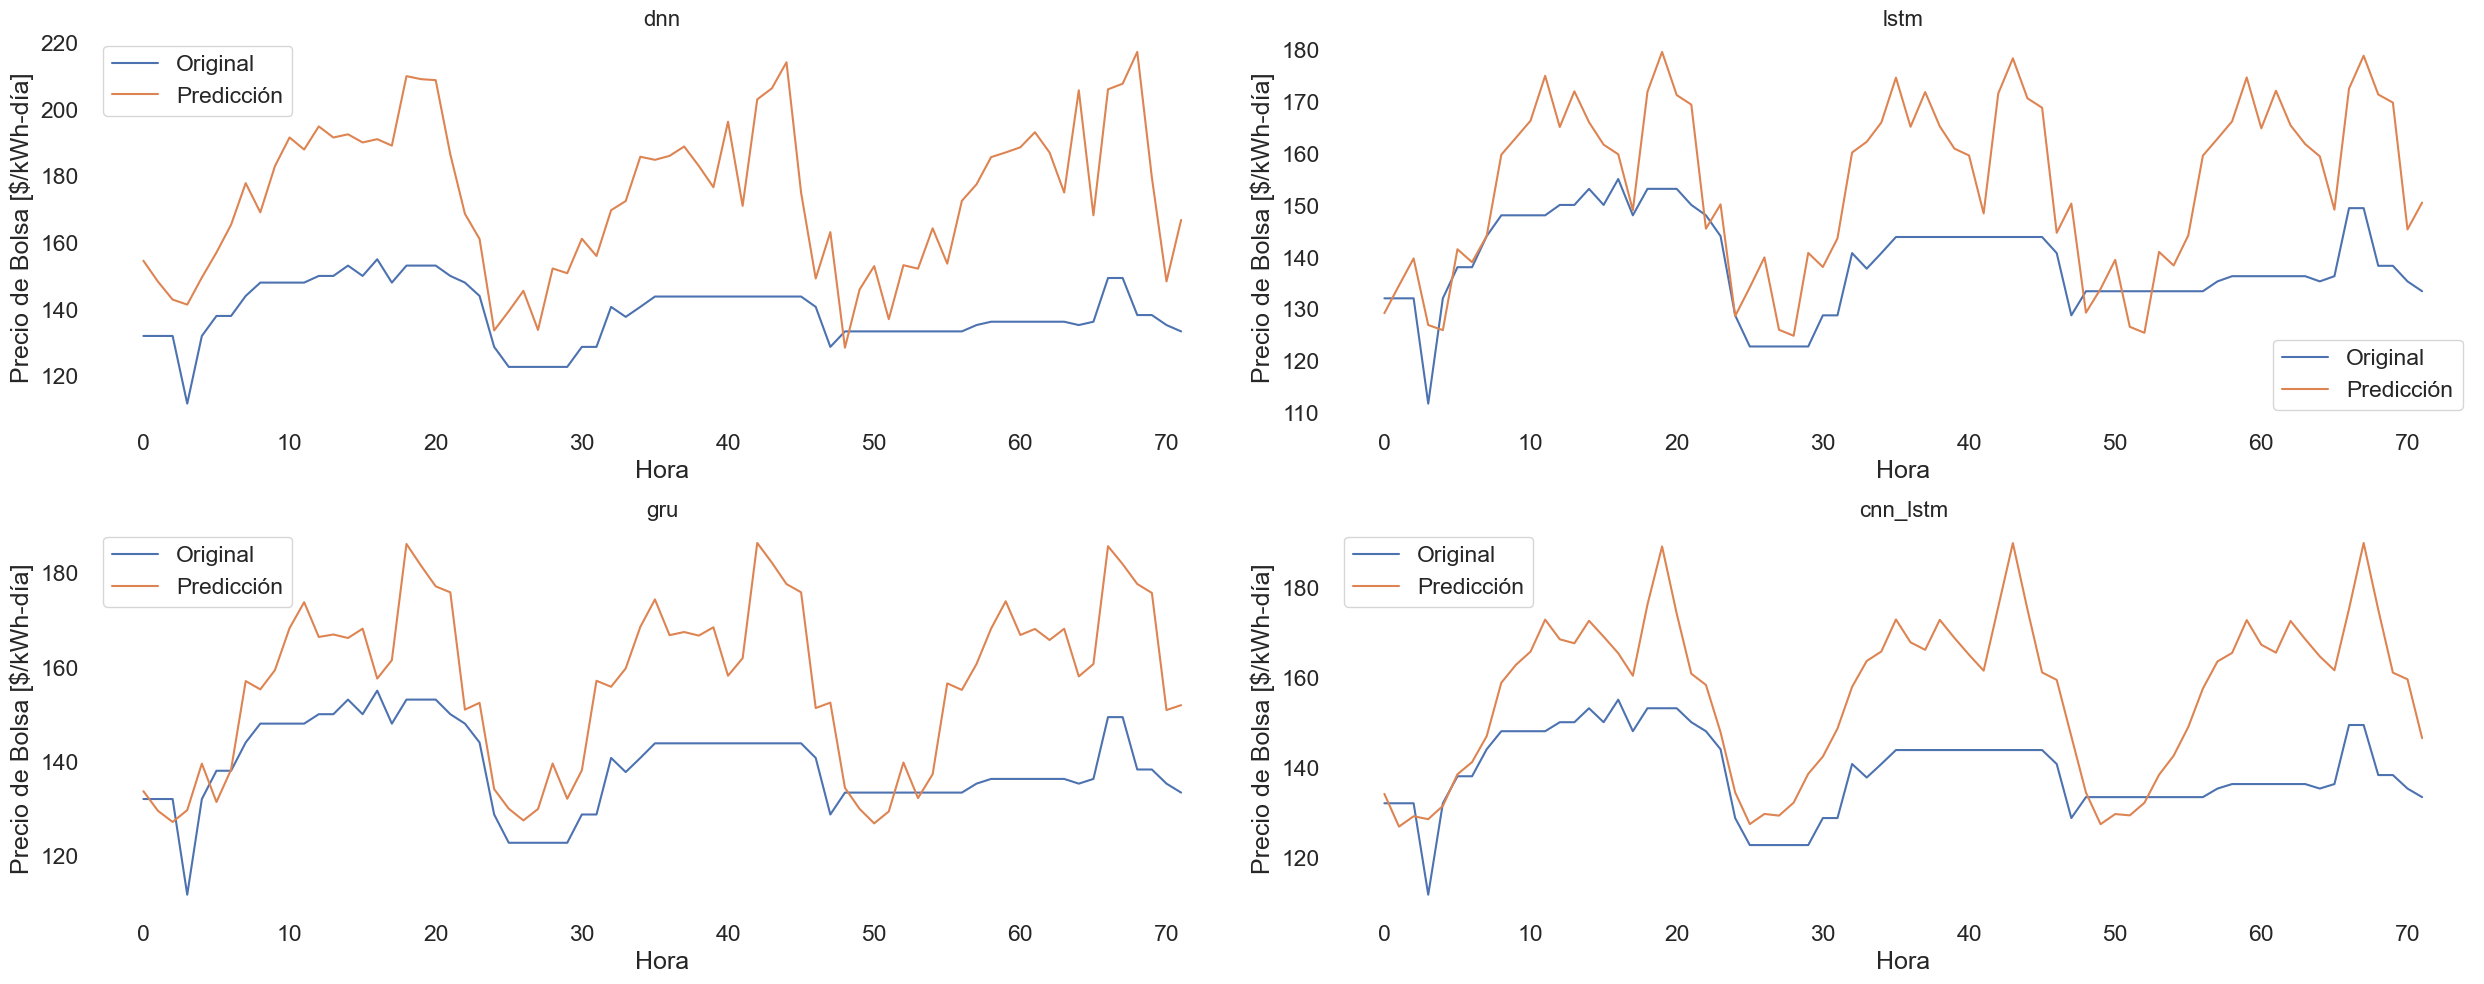

In [21]:
listreg=[i for i in range(3)]
Xtsm=Xts[listreg]
Ytsm=Yts[listreg]

fig, axs = plt.subplots(2,2,figsize=(25,10))  # create a new figure with a default 111 subplot

i=0
i1=0
for (key, val) in model_configs_v.items():

    print(key,val)

    preds = val['model'].predict(Xtsm)

    Ye=Ytsm.reshape(-1,1)
    Ye=scalerP.inverse_transform(Ye)

    Yp=preds[listreg].reshape(-1,1)
    Yp=scalerP.inverse_transform(Yp)

    sns.set(font_scale=1.5,rc={'font.size': 12, 'axes.titlesize': 16})
    axs[i1,i].plot(Ye, label='Original')
    axs[i1,i].plot(Yp, label='Predicción')
    axs[i1,i].set_title(key)
    axs[i1,i].set_xlabel("Hora")
    axs[i1,i].set_ylabel("Precio de Bolsa [$/kWh-día]")
    axs[i1,i].legend(['Original','Predicción'],facecolor='white')
    axs[i1,i].set_facecolor('white')

    i=i+1
    if i==2:
        i1=1
        i=0

plt.tight_layout()  